   #  1. Data Preparation

## Preparing Environement

In [233]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import copy as cp
import seaborn as sns

import helpers as hlp
%aimport helpers
from external import kMedoids


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import plotly.plotly as plty
import plotly.graph_objs as go

from IPython.display import display

#printing
pd.options.display.float_format = '{:,.2f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading raw data

In [285]:
interim_path = "..\\data\\interim\\"
raw_path = "..\\data\\raw\\"
row_header = 'Product'


file_name = "HistPerProduct_p2c1.csv"
file_name = "HistPerProduct_p2c4_jour.csv"
df_HistPerProduct_p2c1 = pd.read_csv(interim_path + file_name , sep = ";", encoding = 'utf-8', header = 0)
product_raw_df = df_HistPerProduct_p2c1
cols = product_raw_df.columns.values
cols[0]  = row_header
product_raw_df.columns =cols


#adding other features
file_name = "bnd_products_desc.csv"

product_desc_df = pd.read_csv(raw_path+file_name, sep=';', encoding='iso8859_2')[['Product Group key','Description']]\
                    .drop_duplicates(subset=['Product Group key'])\
                    .dropna()
        

#Join with descriptions
desc_df = product_raw_df.join(product_desc_df.set_index('Product Group key'),on='Product',how='left')[['Product','Description']]\
                    .fillna("")


display(product_raw_df.head())


Product  04/01/2016  05/01/2016  06/01/2016  07/01/2016  08/01/2016  \
0  GBA001AUC180FS        0.00        6.00        4.00        6.00        0.00   
1  GBA001BND060FS        0.00        0.00        0.00        0.00        0.00   
2  GBA001BND060SS    1,006.00      917.00      837.00    1,170.00    1,016.00   
3  GBA001BND160FS      358.00      308.00      372.00      318.00      578.00   
4  GBA001BND250FS        8.00        0.00        0.00        8.00        0.00   

   09/01/2016  10/01/2016  11/01/2016  12/01/2016     ...      14/01/2018  \
0       10.00        0.00        2.00        8.00     ...            0.00   
1        0.00        0.00        0.00        0.00     ...            0.00   
2    1,121.00       11.00      913.00      906.00     ...            0.00   
3      438.00        0.00      370.00      244.00     ...            0.00   
4        0.00        0.00        8.00        0.00     ...            0.00   

   15/01/2018  16/01/2018  17/01/2018  18/01/2018  19/01/2018  20/01/2018  \
0        0.00        0.00        0.00        0.00        0.00        0.00   
1        0.00        0.00        0.00        0.00        0.00        0.00   
2        0.00        0.00        0.00        0.00        0.00        0.00   
3        0.00        0.00        0.00        0.00        0.00        0.00   
4        0.00        0.00        0.00        0.00        0.00        0.00   

   21/01/2018  22/01/2018  23/01/2018  
0        0.00        0.00        0.00  
1        0.00        0.00        0.00  
2        0.00        0.00        0.00  
3        0.00        0.00        0.00  
4        0.00        0.00        0.00  

[5 rows x 752 columns]

## Cleaning Series
A series of cleaning functions is applied to raw data in order to get rid of __irrelevant and "dirty" data__ with patterns that could disrupt the model.

Each function has a **threashold** parameter in order to adapt the filtering

### Trimming Zeros from series
Remove empyt data on the two sides

In [286]:
product_df = product_raw_df.fillna(0).iloc[:,1:].copy()
tail = 0
#drop first column if zeros
while (product_df.iloc[:,1] == 0).all():
    product_df.drop(product_df.columns[1], axis=1, inplace=True) 
    
#drop last columns if zeros
while (product_df.iloc[:,-1] == 0).all():
    product_df.drop(product_df.columns[-1], axis=1, inplace=True)
    tail += 1
    
print("The last %d values (complete zeros) of each series have been dropped "%tail)   
product_df.head()

The last 57 values (complete zeros) of each series have been dropped 


04/01/2016  05/01/2016  06/01/2016  07/01/2016  08/01/2016  09/01/2016  \
0        0.00        6.00        4.00        6.00        0.00       10.00   
1        0.00        0.00        0.00        0.00        0.00        0.00   
2    1,006.00      917.00      837.00    1,170.00    1,016.00    1,121.00   
3      358.00      308.00      372.00      318.00      578.00      438.00   
4        8.00        0.00        0.00        8.00        0.00        0.00   

   10/01/2016  11/01/2016  12/01/2016  13/01/2016     ...      18/11/2017  \
0        0.00        2.00        8.00        4.00     ...            0.00   
1        0.00        0.00        0.00        0.00     ...          112.00   
2       11.00      913.00      906.00      814.00     ...          278.00   
3        0.00      370.00      244.00      303.00     ...          428.00   
4        0.00        8.00        0.00        0.00     ...            6.00   

   19/11/2017  20/11/2017  21/11/2017  22/11/2017  23/11/2017  24/11/2017  \
0        0.00        0.00        0.00        0.00        0.00        0.00   
1        0.00      128.00      104.00      104.00      112.00      104.00   
2        0.00      314.00      214.00      254.00      278.00      298.00   
3       48.00      362.00      308.00      882.00      904.00    1,466.00   
4        0.00        6.00        0.00        0.00        6.00        0.00   

   25/11/2017  26/11/2017  27/11/2017  
0        0.00        0.00        0.00  
1       90.00        0.00      108.00  
2      250.00        0.00      290.00  
3      618.00       64.00      566.00  
4        6.00        0.00        6.00  

[5 rows x 694 columns]

### Keep last year only

In [287]:
t= 365

product_df = product_df.iloc[:,-t:]

### Trailing Zeros: No longer sold
Remove the products that werent sold in the **last 15 weeks**

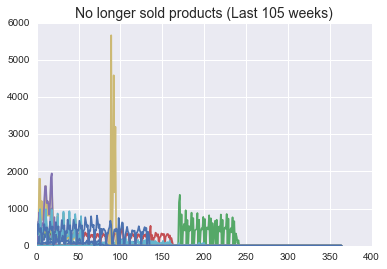

Series With 105 trailing zeros are removed
Removed: 103 , Remaining: 376


In [288]:
t = 15 * 7

#mask on the t last columns being >0
mask = (product_df.iloc[:,-t:]==0).all(axis=1)

for index, row in product_df[mask].iterrows():
    plt.plot(list(row))
plt.title("No longer sold products (Last %d weeks)"%t,size=14)
plt.show()

product_raw_df[mask].to_csv("../reports/stopped_last_105j.csv",sep=';',encoding='utf-8')


product_df = product_df[~mask]
print("Series With %d trailing zeros are removed"%t)
print("Removed: %d , Remaining: %s"%(mask.astype(int).sum(),product_df.shape[0]))




### Leading Zeros: Recently launched
Remove the products which werent sold in the **25 first weeks**

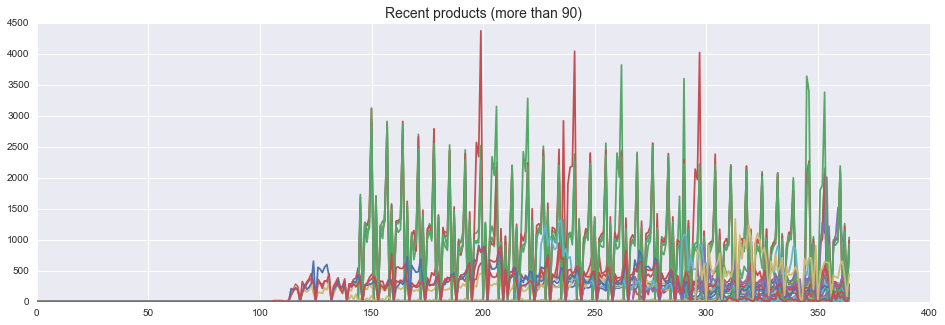

Series With more than 90 zeros are removed
Removed: 39 , Remaining: 337


In [289]:
t = 90

recent =(product_df.iloc[:,:t] == 0).all(axis=1)


plt.figure(figsize=(16,5))
for index, row in product_df[recent].iloc[:,:].iterrows():
    plt.plot(list(row))
plt.title("Recent products (more than %d)"%t,size=14)
plt.show()

product_raw_df.loc[product_df[recent].index,:].to_csv("../reports/recent_first_90j.csv",sep=';',encoding='utf-8')

product_df = product_df[~recent]
print("Series With more than %d zeros are removed"%t)
print("Removed: %d , Remaining: %s"%(recent.astype(int).sum(),product_df.shape[0]))

### Rolling median

Apply a rolling median filter, then remove rare sales

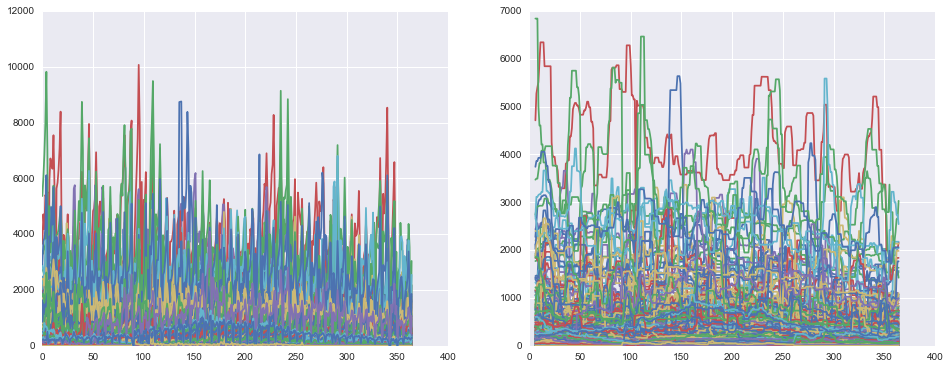

(337, 359)


In [290]:

window = 7

N = product_df.shape[0]
M = product_df.shape[1]


rolled_df = product_df.rolling(window=window,axis=1,center = False,win_type=None).median()#shift(window,axis=1)
s_values = product_df.values
r_values = rolled_df.dropna(axis=1).values

plt.figure(figsize=(16,6))
for i in range(N): 
    plt.subplot(1,2,1)
    plt.plot(np.arange(0,M),s_values[i])
    plt.subplot(1,2,2)
    plt.plot(np.arange(window-1,M),r_values[i])
plt.show()
product_df = rolled_df.dropna(axis = 1)

print(product_df.shape)
product_df.head()
N = product_df.shape[0]
M = product_df.shape[1]

### Mainly Zeros: Rare sales
Remove the products that werent sold for **at least 5 weeks**

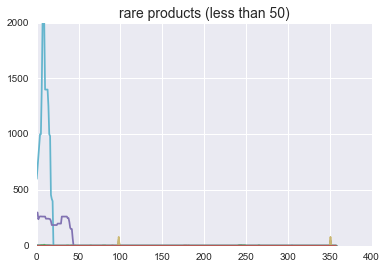

Series With less than 50 values are removed
Removed: 15 , Remaining: 322


In [291]:
t = 50

rare =(product_df.where(product_df==0,other=1.).sum(axis=1)<=t)

for index, row in product_df[rare].iterrows():
    plt.plot(list(row))
plt.title("rare products (less than %d)"%t,size=14)
plt.show()


product_raw_df.loc[product_df[rare].index,:].to_csv("../reports/rare_less_50j.csv",sep=';',encoding='utf-8')

product_df = product_df[~rare]
print("Series With less than %d values are removed"%t)
print("Removed: %d , Remaining: %s"%(rare.astype(int).sum(),product_df.shape[0]))

In [292]:
product_df_clean = product_df

print(product_df.shape)
product_df.head()

(322, 359)


04/12/2016  05/12/2016  06/12/2016  07/12/2016  08/12/2016  09/12/2016  \
1        0.00        0.00        0.00        0.00        0.00        0.00   
2      418.00      426.00      426.00      418.00      426.00      418.00   
3      636.00      598.00      558.00      554.00      554.00      554.00   
6       26.00       20.00       20.00       18.00       18.00       14.00   
8      338.00      338.00      342.00      342.00      346.00      346.00   

   10/12/2016  11/12/2016  12/12/2016  13/12/2016     ...      18/11/2017  \
1        0.00        0.00        0.00        0.00     ...          106.00   
2      412.00      412.00      412.00      412.00     ...          278.00   
3      554.00      554.00      532.00      526.00     ...          428.00   
6       20.00       20.00       10.00       10.00     ...           74.00   
8      346.00      346.00      346.00      328.00     ...          298.00   

   19/11/2017  20/11/2017  21/11/2017  22/11/2017  23/11/2017  24/11/2017  \
1      106.00      112.00      106.00      104.00      104.00      104.00   
2      260.00      278.00      278.00      278.00      278.00      278.00   
3      424.00      424.00      424.00      424.00      424.00      428.00   
6       72.00       72.00       66.00       56.00       56.00       56.00   
8      262.00      278.00      278.00      278.00      278.00      278.00   

   25/11/2017  26/11/2017  27/11/2017  
1      104.00      104.00      104.00  
2      254.00      254.00      254.00  
3      618.00      618.00      618.00  
6       54.00       54.00       54.00  
8      278.00      278.00      288.00  

[5 rows x 359 columns]

### Remove Outliers
Use Winsorizing

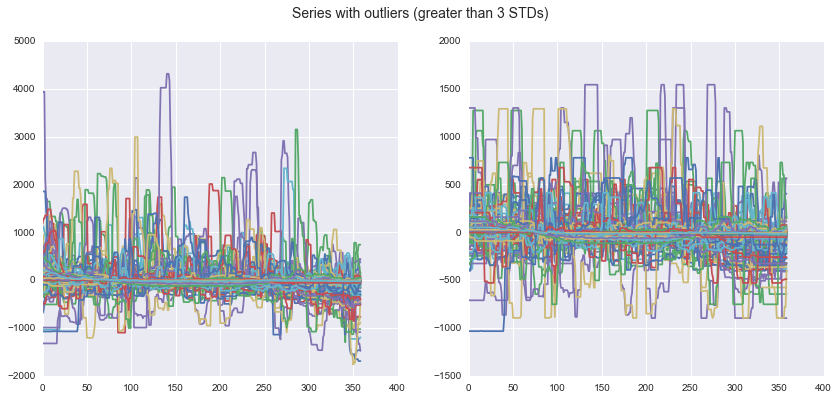

In [293]:
product_df_w = product_df.apply(mstats.winsorize,limits = (0.1,0.1),axis=1)

t = 3

out = (product_df.where(np.abs(stats.zscore(product_df,axis=1))>t,other=0).astype(bool)).any(axis=1)
out2 = (product_df_w.where(np.abs(stats.zscore(product_df_w,axis=1))>t,other=0).astype(bool)).any(axis=1)

plt.figure(figsize=(14,6))

plt.suptitle("Series with outliers (greater than %d STDs)"%t,size=14)#[182,368,382,77,163]
plt.subplot(1,2,1)
for index, row in product_df[out].apply(lambda x: x-x.mean(),axis = 1).iterrows():
    plt.plot(list(row))

plt.subplot(1,2,2)
for index, row in product_df_w[out].apply(lambda x: x-x.mean(),axis = 1).iterrows():
    plt.plot(list(row))

plt.show()
product_df = product_df_w

### Week Resampling

## Pre-process Data
We end up with 248 product. Apply a Z-normalization (subtract the mean and divide by the standard deviation)

In [294]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = product_df.as_matrix().astype(float)

#stanrdize data 
std_scaler = StandardScaler(with_mean=True, with_std=True).fit(data.T)
X_z = std_scaler.transform(data.T).T

#normalize data
minMax_scaler = MinMaxScaler().fit(data.T)
X_n = minMax_scaler.transform(data.T).T

product_codes = product_raw_df[row_header][product_df.index]

product_df_full = pd.DataFrame(X_z, columns = product_df.columns,index=product_df.index)
product_df_full.insert(0,row_header,product_codes)


N,M  = X_z.shape

product_df_full.head()




Product  04/12/2016  05/12/2016  06/12/2016  07/12/2016  08/12/2016  \
1  GBA001BND060FS       -2.39       -2.39       -2.39       -2.39       -2.39   
2  GBA001BND060SS       -1.47       -1.47       -1.47       -1.47       -1.47   
3  GBA001BND160FS        1.71        1.35        0.96        0.92        0.92   
6  GBA001BNR250FS       -0.71       -1.07       -1.07       -1.19       -1.19   
8  GBA001CAR125FS        1.96        1.96        2.05        2.05        2.14   

   09/12/2016  10/12/2016  11/12/2016  12/12/2016     ...      18/11/2017  \
1       -2.39       -2.39       -2.39       -2.39     ...           -2.36   
2       -1.47       -1.47       -1.47       -1.47     ...           -1.47   
3        0.92        0.92        0.92        0.71     ...           -0.29   
6       -1.19       -1.07       -1.07       -1.19     ...            1.99   
8        2.14        2.14        2.14        2.14     ...            1.08   

   19/11/2017  20/11/2017  21/11/2017  22/11/2017  23/11/2017  24/11/2017  \
1       -2.36       -2.29       -2.36       -2.39       -2.39       -2.39   
2       -1.47       -1.47       -1.47       -1.47       -1.47       -1.47   
3       -0.33       -0.33       -0.33       -0.33       -0.33       -0.29   
6        1.99        1.99        1.74        1.13        1.13        1.13   
8        0.28        0.64        0.64        0.64        0.64        0.64   

   25/11/2017  26/11/2017  27/11/2017  
1       -2.39       -2.39       -2.39  
2       -1.47       -1.47       -1.47  
3        1.54        1.54        1.54  
6        1.01        1.01        1.01  
8        0.64        0.64        0.86  

[5 rows x 360 columns]

## Display Cleaned Series

(322, 359)


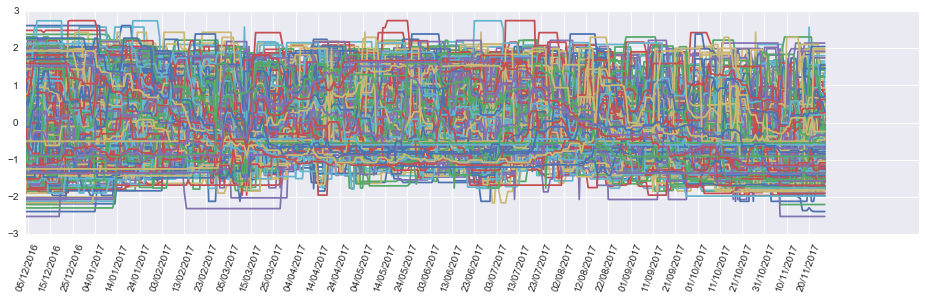

In [295]:
rows = 30
per_row = int(N/rows)+1
row=0
i=1

tf = 10
print(product_df.shape)
plt.figure(figsize=(16,4))

for x in X_z[:]:
    plt.plot(x)

i+=1
plt.xticks(np.arange(0,M)[1::tf], list(product_df.columns)[1::tf], rotation = 70)

plt.show()

## Model Smoothing
Applying a moving average or an other ARIMA filters to the series

### ARIMA Models

# 2. Principal Components Analysis
Apply a PCA on raw data (standardized), plot the the individual cloud then the correlation circle

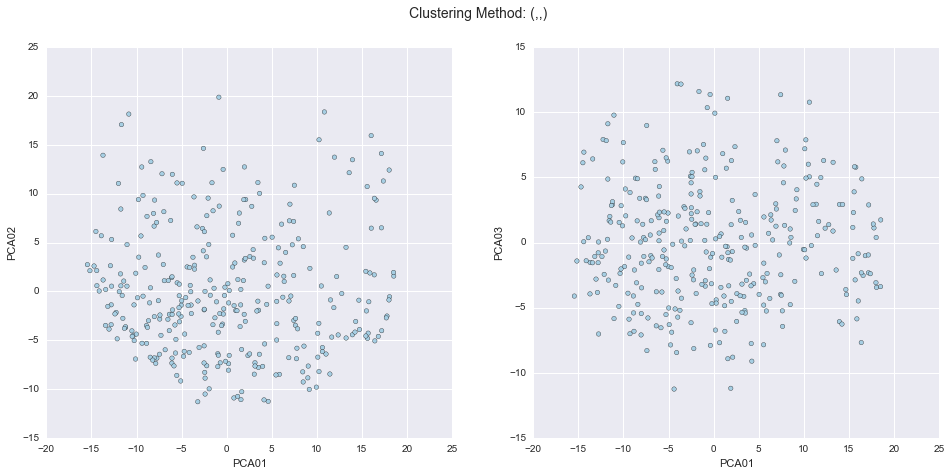

[ 0.24452814  0.13016886  0.06666571  0.04269167  0.03998061]


In [296]:
%matplotlib inline

X = X_z
nb_col=X.shape[1]
pca = PCA(n_components = nb_col)

pca.fit(X)  
princ_axis = pca.components_

X_pca= pca.transform(X)

hlp.Clusters_plot(X= X_pca, labels = np.zeros(len(X_pca)))
inertie = pca.explained_variance_ratio_
print(inertie[0:5])
comp = np.transpose(princ_axis)


# hlp.circleOfCorrelations(comp,inertie,product_df.columns)
plt.show(block = True)

## PCA 01
It regroups products being sold more over time ie __decreasing trend__ over the last two years

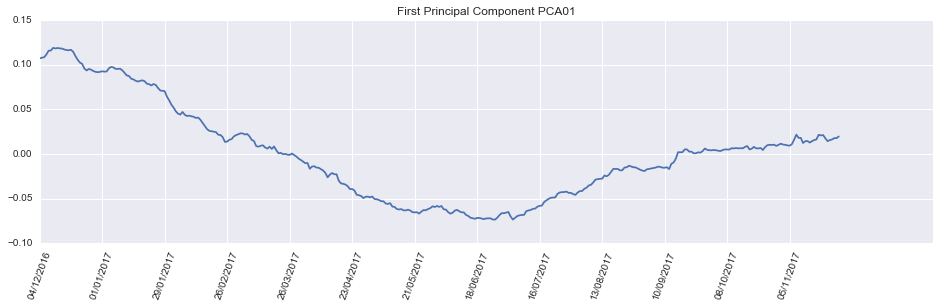

In [301]:
%matplotlib inline

tick_frequency =4 * 7
plt.figure(figsize=(16,4))
plt.title("First Principal Component PCA01")
plt.plot(range(nb_col), princ_axis [0,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

## PCA 02
Opposes products in term of __sales seasonality__ being sold either in cold or hot seasons

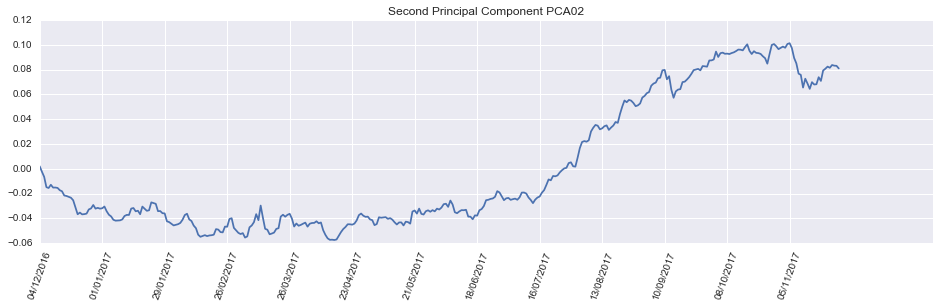

In [302]:
plt.figure(figsize=(16,4))
plt.title("Second Principal Component PCA02")
plt.plot(range(nb_col), princ_axis [1,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

## PCA 03
The curve seems strongly correlated to __one sales period__. Probably of one product 

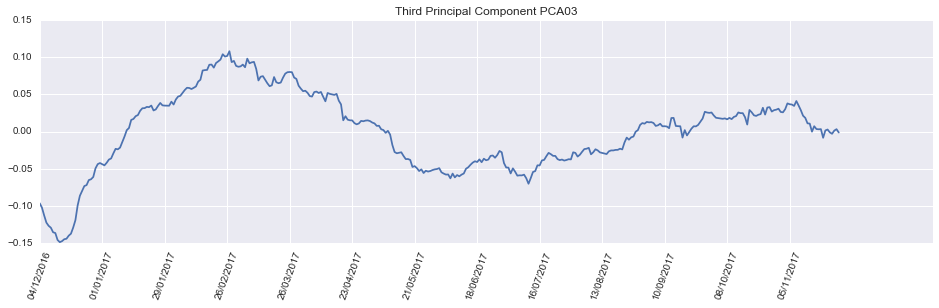

In [303]:
plt.figure(figsize=(16,4))
plt.title("Third Principal Component PCA03")
plt.plot(range(nb_col), princ_axis [2,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

## PCA 04
The curve seems strongly correlated to __one sales period__. Probably of one product 

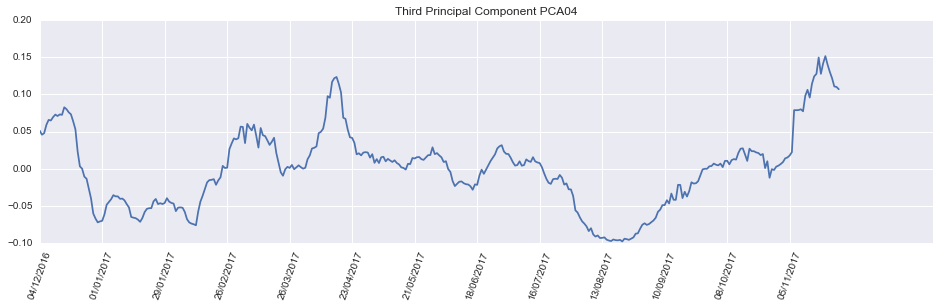

In [304]:
plt.figure(figsize=(16,4))
plt.title("Third Principal Component PCA04")
plt.plot(range(nb_col), princ_axis [3,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

### Plot the samples with the strongest correlation to components
On récupère les examples qui sont le plus corrélés avec un axe principal donné

In [306]:
component = 4
corrSamples = hlp.GetMostCorrelatedTo(X_pca,component,index=product_df.index)
corrSamples.head()


1    2    3     4    5    6    7    8    9    10  ...   313  314  315  \
395 1.31 2.71 3.22 12.37 1.74 0.83 0.45 0.21 0.55 4.84 ...  0.01 0.00 0.00   
212 6.48 1.10 5.62 11.51 1.47 4.82 2.04 1.83 1.56 1.57 ...  0.01 0.00 0.01   
138 7.01 8.92 7.82  9.40 0.13 2.54 5.34 2.48 0.73 1.91 ...  0.00 0.00 0.01   
94  9.75 3.50 2.05  9.36 0.41 3.70 2.14 3.25 1.34 3.06 ...  0.00 0.01 0.00   
181 0.83 8.72 0.73  9.01 0.98 1.19 1.51 4.37 0.17 5.04 ...  0.00 0.00 0.00   

     316  317  318  319  320  321  322  
395 0.01 0.00 0.00 0.01 0.00 0.00 0.00  
212 0.00 0.01 0.00 0.00 0.01 0.00 0.00  
138 0.00 0.01 0.00 0.00 0.00 0.00 0.00  
94  0.00 0.00 0.01 0.01 0.00 0.00 0.00  
181 0.00 0.00 0.00 0.00 0.00 0.00 0.00  

[5 rows x 322 columns]

### Compare the Most Correlated sample to its principal component
On vérifie si la séquence de l'exemple le plus corrélé suit le schéma de l'axe principal

Produit 395


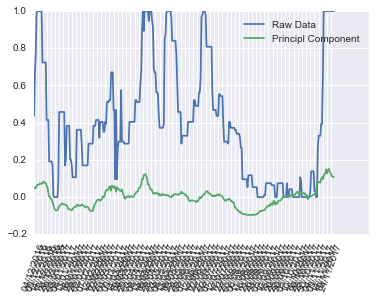

In [307]:
sample = corrSamples.index[0]
print("Produit %d"%sample)
p_axe = princ_axis [component-1,:]
x = product_df.loc[sample]
normalized = (x-min(x))/(max(x)-min(x))

tick_frequency = 5
plt.plot(range(nb_col),normalized, label="Raw Data")
plt.plot(range(nb_col),p_axe , label="Principl Component")
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.legend()
plt.show()

# 3. Modeling - Clustering Algorithms
Try out Hierarchical clustering, kMeans and kMedodis  on raw (cleaned) data. Then, plot the PCA to visualize the result of the clustering on the principal components

## Agglomerative - Automated Cut-Off Selection

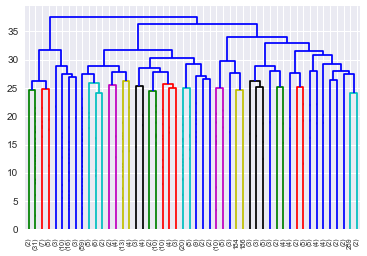

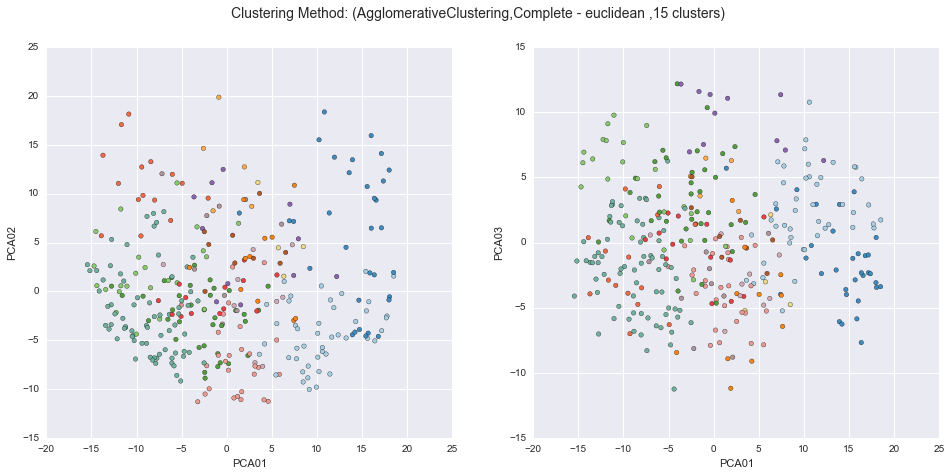

In [308]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
SSE = {}

Z = hierarchy.linkage(X_z, method='complete',metric='euclidean')
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p=50, leaf_rotation=90., leaf_font_size=7., show_contracted=True)
plt.show()



plt.figure()
labels_h_cc = hierarchy.fcluster(Z, t=15 ,criterion = 'maxclust')
hlp.Clusters_plot(X= X_pca, labels = labels_h_cc,info=["AgglomerativeClustering","Complete - euclidean ","%d clusters"%len(set(labels_h_cc))])


SSE["Agg_complete"] = hlp.getSSE(X_z,X_z[labels_h_cc])

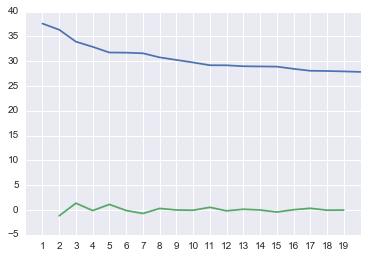

clusters: [ 3  2  5  7 11 15 17  8 12 13  4  6 16 10 18 19 14  9]


In [309]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xticks(np.arange(1,len(last)))
plt.show()
best_ks = np.abs(acceleration_rev).argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

### K-Means: Validate different numbers of clusters

clusters: [ 9 32 38 13 19 11 17 22 28 24 34 15 30 21 26 40 36  7]


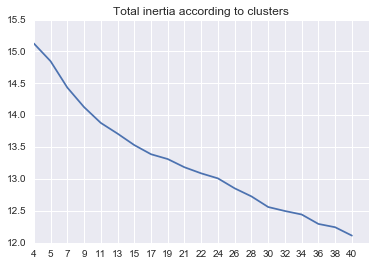

In [310]:
%matplotlib inline
clusters= np.linspace(4,40,20).astype(int)
inertia = []
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=0).fit(X_z)
    inertia += [np.sqrt(kmeans.inertia_/len(kmeans.labels_))]
    
inertia = np.array(inertia)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),inertia)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)



acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
#plt.plot(np.arange(2,len(clusters)), acc)
best_ks = acc.argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:",clusters[k])
plt.show()


## Ward Clustering

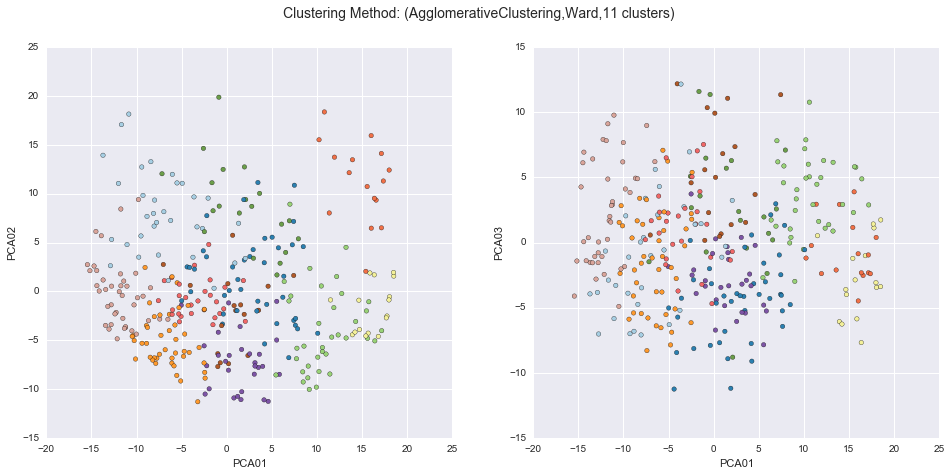

In [311]:
n_cluster = 11

from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward').fit(X_z)
label = ward.labels_

SSE['Ward'] = hlp.getSSE(X_z,X_z[label])
hlp.Clusters_plot(X= X_pca, labels = label,info=["AgglomerativeClustering","Ward","%d clusters"%len(set(label))])

## K-means

In [312]:
%matplotlib inline

kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_z)
label = kmeans.labels_
labels_kmeans = label

SSE["kMeans"] = hlp.getSSE(X_z,X_z[labels_kmeans])

### PCA representation of the clustering

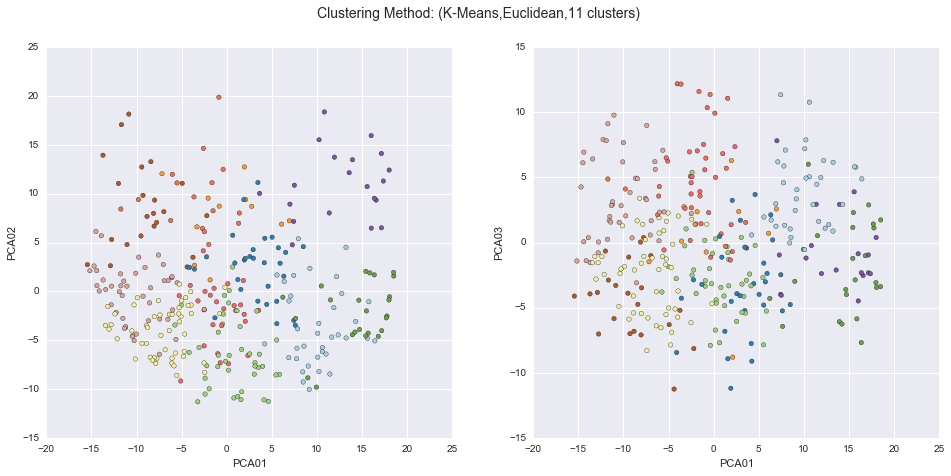

In [313]:
X = X_pca[:,:3]
hlp.Clusters_plot(X= X_pca, labels = label,info=["K-Means","Euclidean","%d clusters"%len(set(label))])

### TSNE representation of the clustering

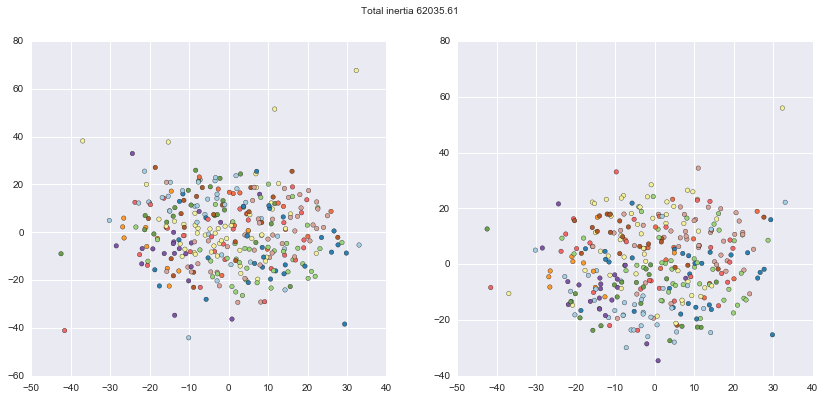

In [314]:
%matplotlib inline


X_tsne = TSNE(n_components = 3).fit_transform(X_z)

plt.figure(figsize=(14,6))
colors = [str(item/255.) for item in labels_kmeans]
plt.suptitle("Total inertia %.02f"%kmeans.inertia_)  
plt.subplot(1,2,1)
plt.scatter(X_tsne[:,0],X_tsne[:,1],cmap ="Paired" ,c=colors)
plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0],X_tsne[:,2],cmap ="Paired" ,c=colors)
plt.show(block = True)

## Custom Distances

In [315]:
from scipy.stats import spearmanr
def spearmanr_dist(x,y):
    rho, pval = spearmanr(x,y)
    return rho


r,p = spearmanr(X_z)
np.fill_diagonal(r,0)

In [316]:
from external import kMedoids
from scipy.spatial.distance import pdist,squareform

n_obs = X_z.shape[1]
corr_distance = squareform(pdist(X_z, 'correlation'))
euclid_distance = squareform(pdist(X_z, 'euclidean'))
sqcorr_distance = corr_distance**2
#spearman_distance = squareform(pdist(X_z, lambda u, v: spearmanr_dist(u,v)))



## K-medoids (Correlation distance)

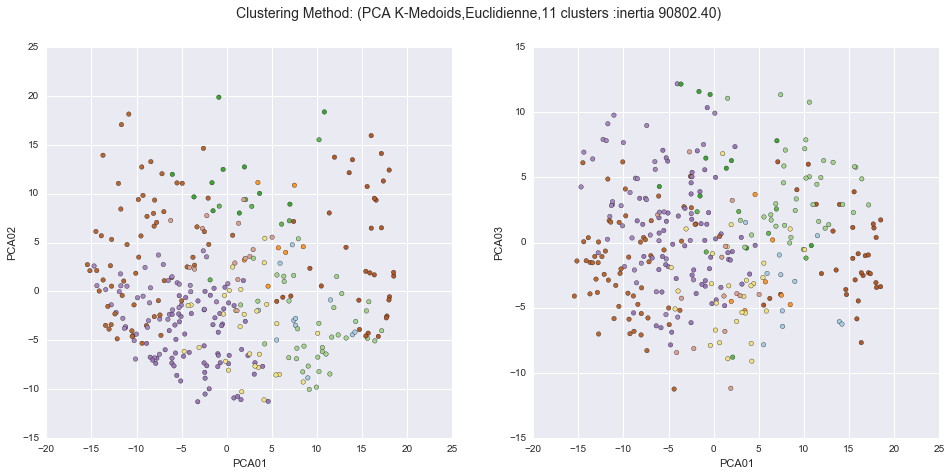

In [317]:
label, medoids = kMedoids.cluster(euclid_distance,k= n_cluster)
labels_kmedoids = label

labels_kmedoids_corr,medoids = kMedoids.cluster(corr_distance,k= n_cluster)
labels_kmedoids_spear,medoids = kMedoids.cluster(corr_distance,k= n_cluster)


SSE["kMedoids"] = hlp.getSSE(X_z,X_z[labels_kmedoids])
SSE["kMedoids_corr"] = hlp.getSSE(X_z,X_z[labels_kmedoids_corr])
SSE["kMedoids_spear"] = hlp.getSSE(X_z,X_z[labels_kmedoids_spear])


hlp.Clusters_plot(X= X_pca, labels = label
                  ,info=["PCA K-Medoids","Euclidienne","%d clusters :inertia %.2f"%(len(set(label)),SSE["kMedoids"])])
#hlp.Clusters_plot(X= X_tsne, labels = label,info=["TSNE K-Medoids","Correlation","%d clusters"%len(set(label))])

In [319]:
for k,v in SSE.items():
    print(" \"%s\" : %.2f"%(k,v))

 "Agg_complete" : 219580.03
 "Ward" : 184640.13
 "kMedoids_spear" : 98987.56
 "kMeans" : 232595.41
 "kMedoids_corr" : 92017.58
 "kMedoids" : 90802.40


# Save Clustering Results

In [320]:
processed_path = "..\\data\\processed\\"
file_name = "p2c1_clustering_clean.csv"
file_name = "p2c1_clustering_clean_jour.csv"

def labels_to_df(labels):
    clusters = dict()

    for i,l in enumerate(list(set(labels))):
        clusters[l] = i+1

    groups = list(product_df_full[row_header])
    rows=[]
    for i,g in enumerate(groups):
        c = labels[i]
        rows.append([g,clusters[c],groups[c]])


    label_df = pd.DataFrame(rows,index = labels,columns = ["Product Group key","Cluster","Centroid"])
    return label_df




eucl_df = labels_to_df(labels_kmedoids)
corr_df = labels_to_df(labels_kmedoids_corr)
spear_df = labels_to_df(labels_kmedoids_spear)

eucl_df.to_csv(interim_path+file_name, sep=';', encoding='utf-8')
corr_df.to_csv(interim_path+"corr_"+file_name, sep=';', encoding='utf-8')
spear_df.to_csv(interim_path+"spear_"+file_name, sep=';', encoding='utf-8')

# Display Clustering Results

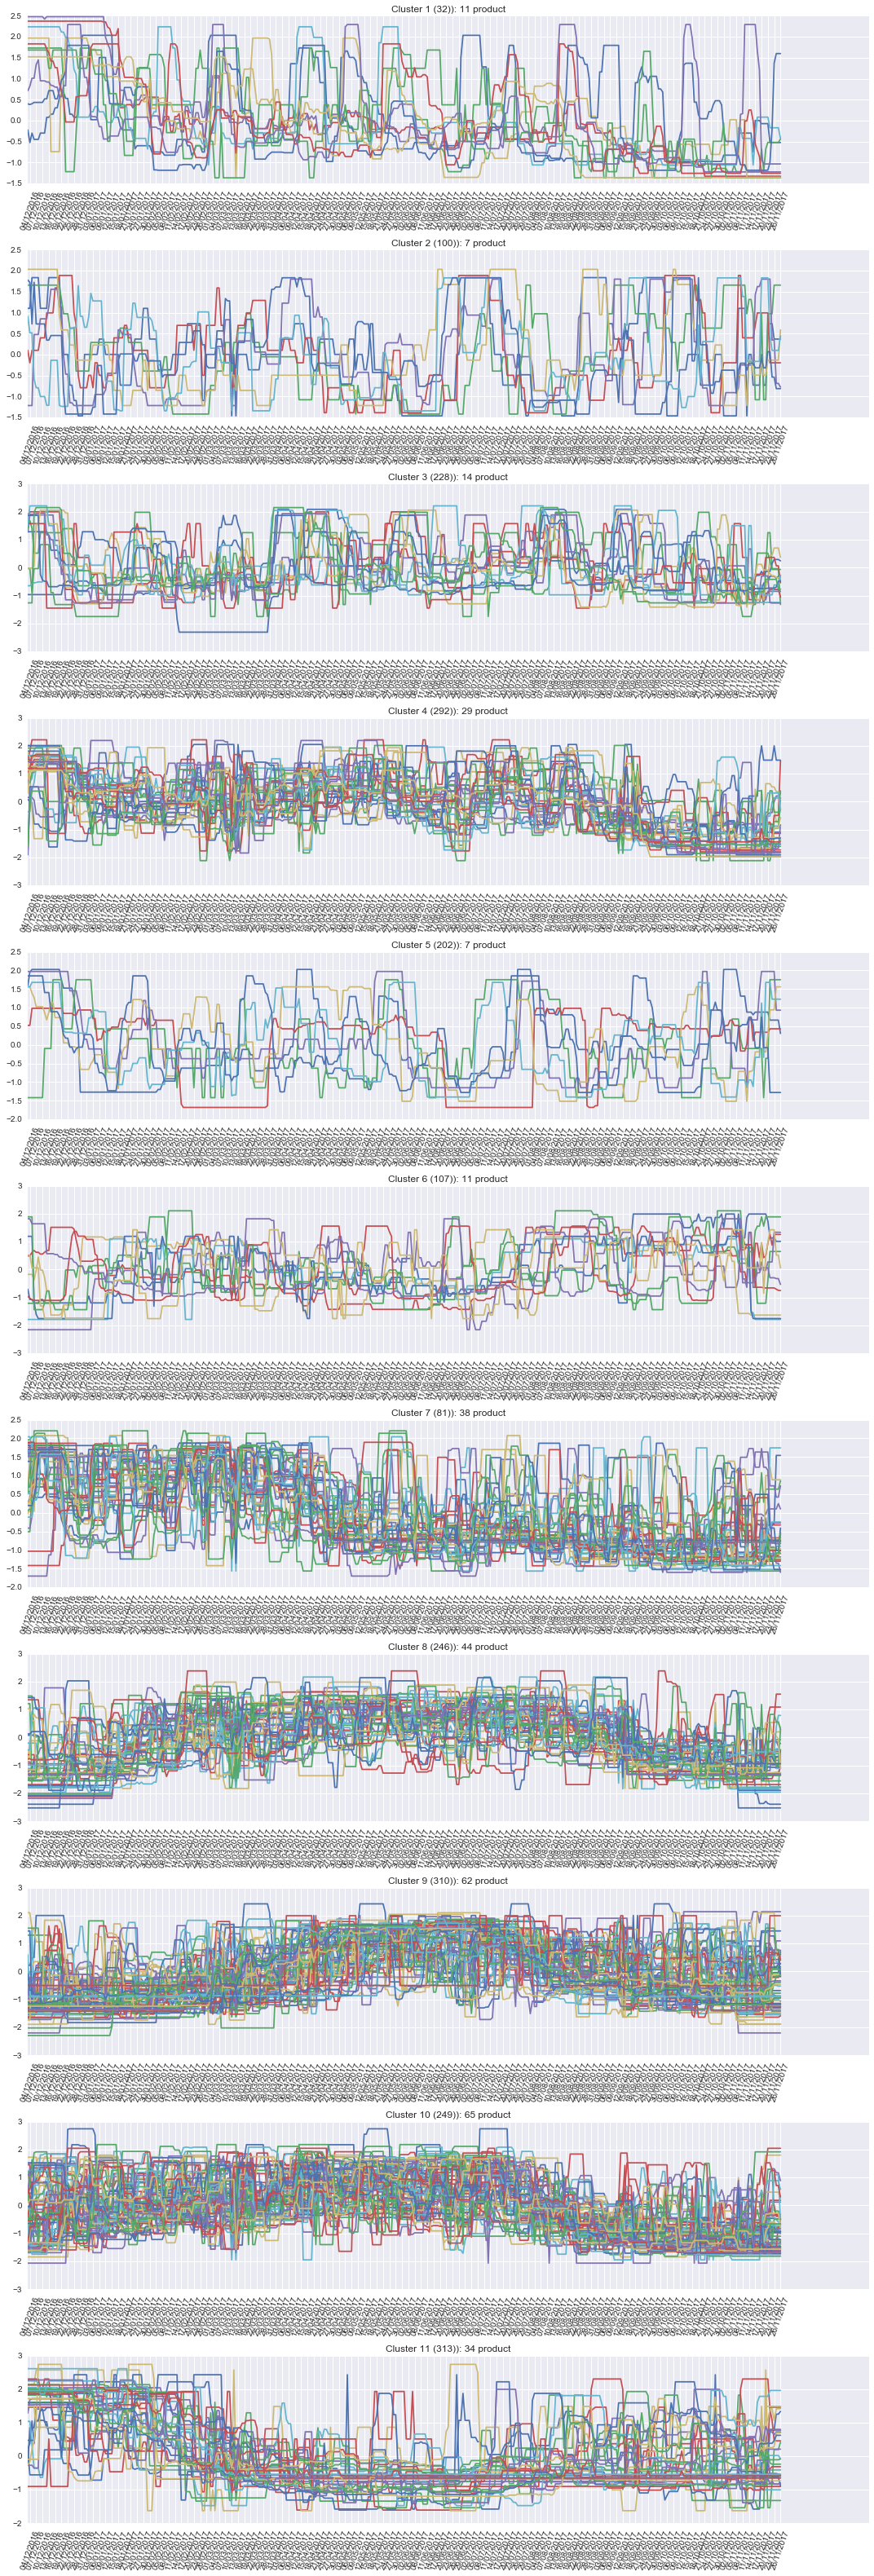

In [321]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = eucl_df)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = corr_df)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = spear_df)

## BIRCH Algorithm

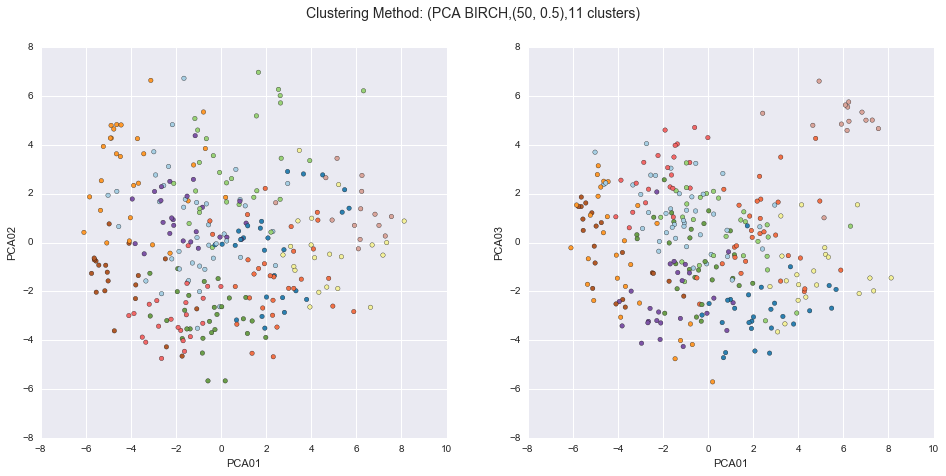

In [72]:
label = Birch(n_clusters= n_cluster, threshold=0.5, compute_labels=True).fit_predict(X_z)
labels_birch = label

SSE["Birch"] = hlp.getSSE(X_z,X_z[labels_birch])

hlp.Clusters_plot(X= X_pca, labels = label,info=["PCA BIRCH","(50, 0.5)","%d clusters"%len(set(label))])

## SOM

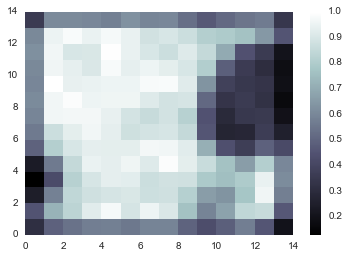

In [37]:
from minisom import MiniSom   


som = MiniSom(14, 14, 104, sigma=0.5, learning_rate=0.01) # initialization of 6x6 SOM

som.train_batch(X_z, 1000) # trains the SOM with 100 iterations

# Plotting the response for each pattern in the iris dataset
plt.bone()
plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

qnt = som.quantization(X_z)
x,y = som.winner(X_z[0])


plt.show()




# SOM with SOMpy

In [280]:
import sompy
mapsize = [14,14]
som = sompy.SOMFactory().build(Data1, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  
# this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose='info')  # verbose='debug' will print more, and verbose=None wont print anything

# Fuzzy c-means

In [264]:
import skfuzzy as fuzz

ncenters = n_cluster
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_z.T, ncenters, 2, error=0.005, maxiter=1000, init=None)



labels_fuzzy = np.argmax(u, axis=0)

## Representation methods
### PAA_SAX representation

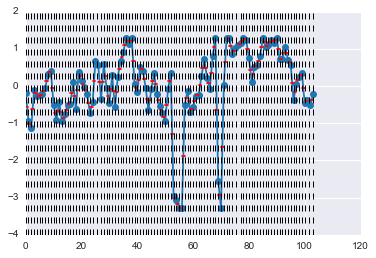

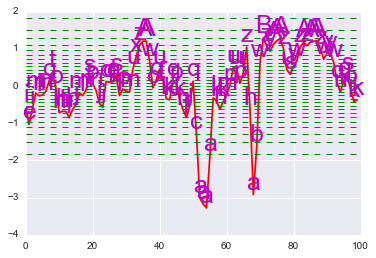

In [393]:
from pyts.transformation import PAA,SAX
from pyts.visualization import plot_paa, plot_sax
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
ts = X_z[0].reshape(1,-1)

paa_win = 100
sax_bin = 30


#PAA example
paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
X_paa = paa.transform(ts)
plot_paa(ts[0], window_size=None, output_size=paa_win, overlapping=True, marker='o')

#SAX example
sax = SAX(n_bins=sax_bin, quantiles='gaussian')
X_sax = sax.transform(X_paa)
plot_sax(X_paa[0], n_bins=sax_bin, quantiles='gaussian')
plt.show()

#Extract SAX vector
X_SAX= []
for x in X_z:
    ts = x.reshape(1,-1)
    paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
    X_paa = paa.transform(ts)
    sax = SAX(n_bins=sax_bin, quantiles='gaussian')
    X_sax = sax.transform(X_paa)[0]
    X_SAX.append(list(X_sax))

#Cast back to int
X_SAX = np.array(X_SAX).astype('|S1')
X_SAX = X_SAX.view(np.uint8) - 98
# X_z = X_SAX
# N,M  = X_z.shape
